In [1]:
#@title

import jax
import itertools
import numpy as onp
import jax.numpy as np
import matplotlib.pyplot as plt
plt.style.use('matplotlibrc')
import ipywidgets as widgets

from jax.numpy.linalg import inv, pinv
from scipy.linalg import solve_discrete_are as dare
from jax import jit, grad
from IPython import display
from toolz.dicttoolz import valmap, itemmap
from itertools import chain

from pomps import *
from resampling import *
from filtering import *
from optim import *

from tqdm import tqdm


2023-07-28 15:05:51.788186: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## A simple dynamical system
Defines a discrete-time linear dynamical system with Gaussian noise that mirrors 1d kinematics.

Below $\mathbf{x}_t$ is the state, $\mathbf{w}_t$ is the perturbation.

$$ \mathbf{x}_{t+1} = A\mathbf{x}_t + \mathbf{w}_t $$ 
$$ \mathbf{y}_{t+1} = C\mathbf{x}_{t+1} + \mathbf{\epsilon}_t $$

$$ A = \begin{bmatrix}
1 & 1\\
0 & 1
\end{bmatrix}$$

$$ C = \begin{bmatrix}
1 & 0\\
0 & 1
\end{bmatrix}$$

In [2]:
#import warnings
#warnings.filterwarnings('ignore')

fixed = False

angle = 0.2
angle2 = angle if fixed else -0.5
A = np.array([[np.cos(angle2), -np.sin(angle)], 
              [np.sin(angle), np.cos(angle2)]])
#A = -1e-4*np.eye(2)
C = np.eye(2)#0
Q = np.array([[1, 1e-4], 
              [1e-4, 1]])/100
#Q = np.eye(2)/10
R = np.array([[1, .1], 
              [.1, 1]])/10
#R = np.eye(2)
x = np.ones(2)

100%|██████████| 40/40 [00:00<00:00, 116.92it/s]


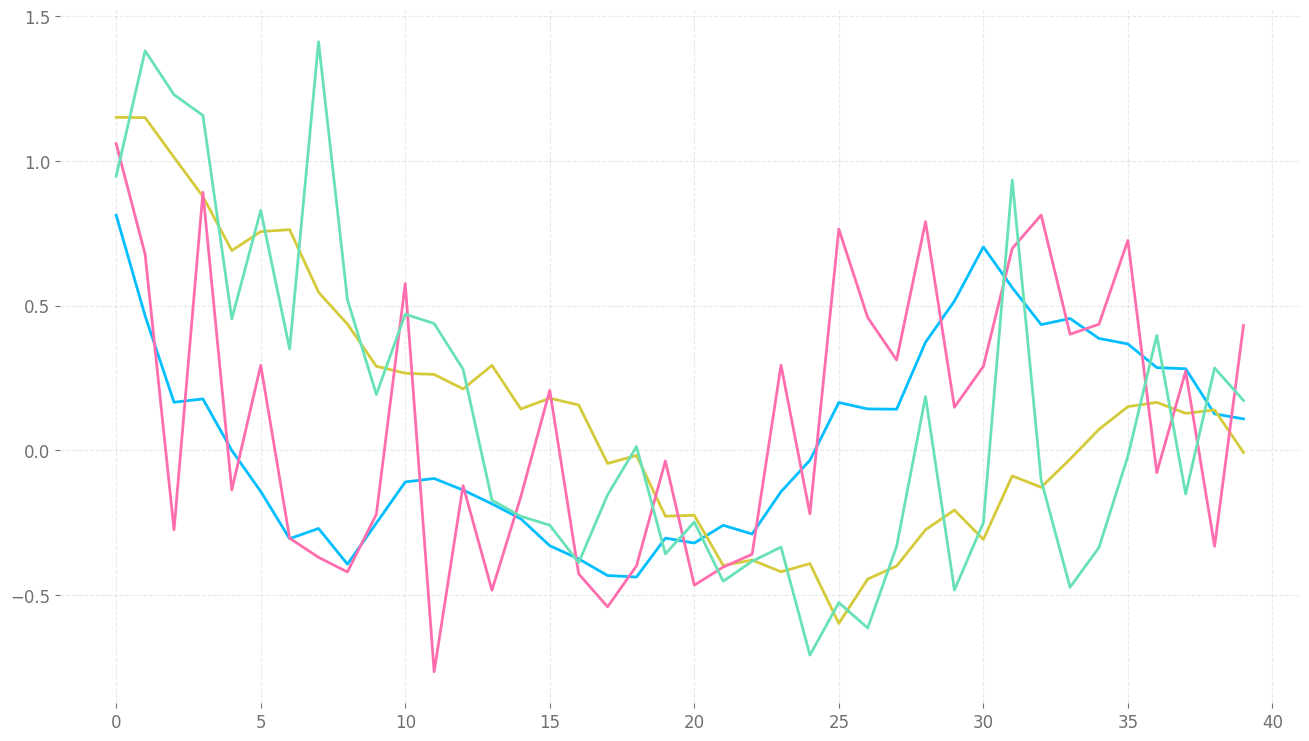

In [3]:
xs = []
ys = []
T = 40
for i in tqdm(range(T)):
    randint = onp.random.randint(0, 10000)
    x = jax.random.multivariate_normal(key=jax.random.PRNGKey(randint), mean=A@x, cov=Q)
    randint = onp.random.randint(0, 10000)
    y = jax.random.multivariate_normal(key=jax.random.PRNGKey(randint), mean=C@x, cov=R)
    xs.append(x)
    ys.append(y)
xs = np.array(xs)
ys = np.array(ys)
plt.figure(figsize=(16,9))
plt.plot(xs)
plt.plot(ys)

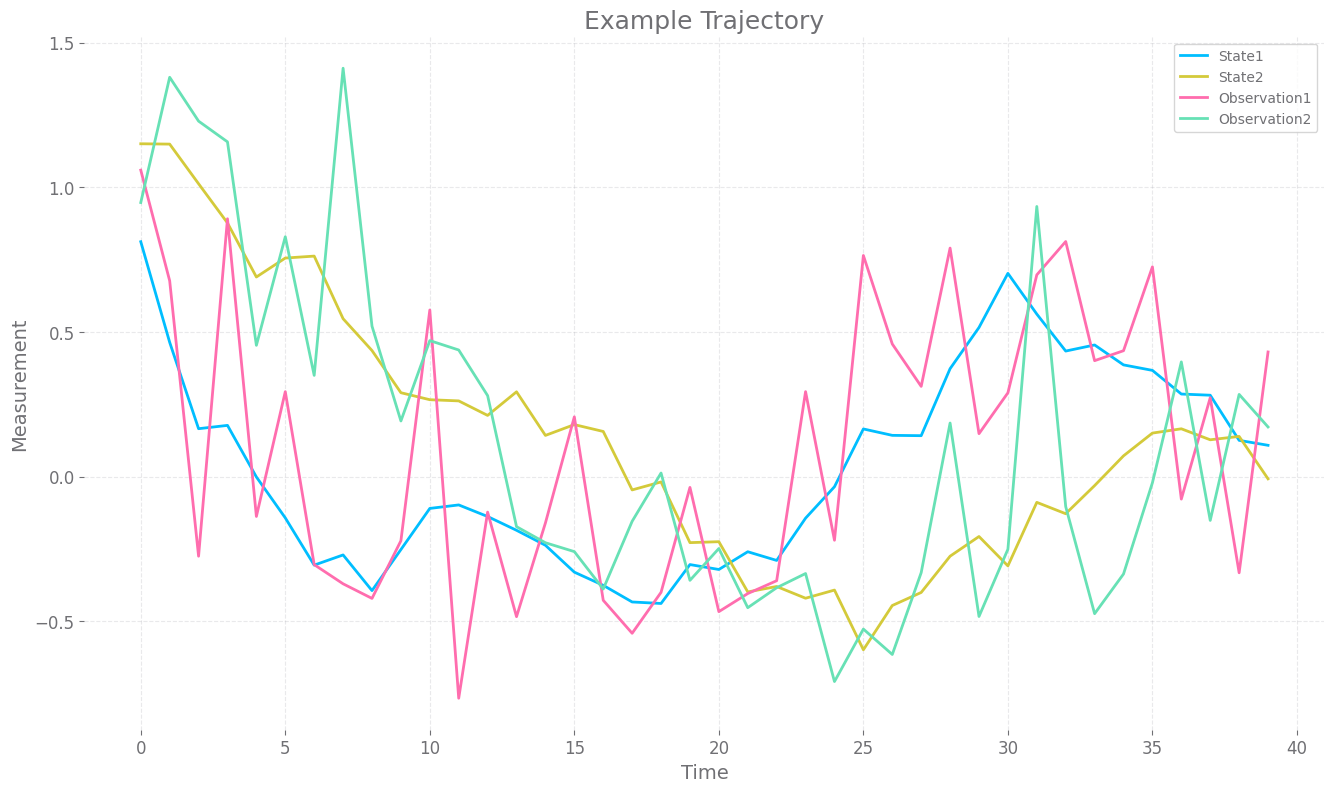

In [4]:
plt.figure(figsize=(16,9))
plt.plot(xs[:,0], label='State1')
plt.plot(xs[:,1], label='State2')
plt.plot(ys[:,0], label='Observation1')
plt.plot(ys[:,1], label='Observation2')
plt.xlabel('Time')
plt.ylabel('Measurement')
plt.legend()
plt.title('Example Trajectory')
plt.savefig('imgs/trajs.png')

In [5]:


#rprocess = jax.jit(rprocess)
#dmeasure = jax.jit(dmeasure) #jax.jit(jax.vmap(dmeasure, in_axes=(None,0,None)))
loss_grad = (jax.vmap(jax.grad(dmeasure, argnums=1), in_axes=(None,0,None)))


        mw = np.max(weights)
        reward = mw + np.log(np.mean(np.exp(weights - mw))) # p(y_t | x_{t,1:J}, \theta)
        rewards.append(reward)
        
        if reinforce:
            log_probs = weights#[counts]
            # log_probs is shape (Np,), contains (\log p(y_t | x_{t,j}^F, \theta))_j
            baseline = np.exp(reward)
            obj += np.mean(log_probs) * np.exp(reward) #take reward to be loglik over all particles
            #obj += np.mean(log_probs * (np.exp(log_probs))) #elementwise sum reward for each particle

In [12]:
import pykalman
kf = pykalman.KalmanFilter(transition_matrices=A, observation_matrices=C, 
                      transition_covariance=Q, observation_covariance=R)#.filter(ys)
kf.loglikelihood(ys)

-37.52332167566961

In [26]:
theta = np.array([A, C, Q, R])
-pfilter(theta, ys, 100000, None, 0)

Array(-37.207634, dtype=float32)